# Mine the Data Server Manager History

This notebook demonstrated how to connect to a Data Server Manager repository database, access historical data collected in the repository and analyze it using DataFrames.

Data Server Manager stores very useful information in its historical repository database that you can directly access through SQL. (There is more information on accessing this information in the [DSM Wiki](https://www.ibm.com/developerworks/community/wikis/home?lang=en#!/wiki/W377e39cb6e13_42a7_b752_005b67cb913f/page/Repository%20View%20THROUGHPUT_WORKLOAD "DSM Wiki").

This notebook retrieves data from the Data Server Manager monitoring history and maps out resource usages across your Db2 family enterprise. (You will need connection privileges to the Data Server Manager repository database.) It creates a view in the repository database that provides a list of databases and workloads in each database for each data point collected. The values collected are key resource metrics: CPU seconds, Transactions, and Logical Reads. It then maps out a pivot table for the total resources or throughput per database and workload by week for each database in your Data Server Manager monitoring enterprise.

## Db2 Extensions
This tutorial relies on a Jupyter notebook extensions, commonly refer to as a "magic" commands. The beginning of all of the notebooks begin with the following command which will load the extension and allow the remainder of the notebook to use the %sql magic command.
<pre>
&#37;run db2.ipynb
</pre>
The cell below will load the Db2 extension. Note that it will take a few seconds for the extension to load, so you should generally wait until the "Db2 Extensions Loaded" message is displayed in your notebook.

In [1]:
%run db2.ipynb

DB2 Extensions Loaded.


In [26]:
# load pandas for dataframe support and numpy for statistical manipulation and matplot for graphing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Connections to Db2

Before any SQL commands can be issued, a connection needs to be made to the Db2 database that you will be using. The connection can be done manually (through the use of the CONNECT command), or automatically when the first %sql command is issued.

The Db2 magic command tracks whether or not a connection has occured in the past and saves this information between notebooks and sessions. When you start up a notebook and issue a command, the program will reconnect to the database using your credentials from the last session. In the event that you have not connected before, the system will prompt you for all the information it needs to connect. This information includes:

- Database name (SAMPLE) 
- Hostname - localhost (enter an IP address if you need to connect to a remote server) 
- PORT - 50000 (this is the default but it could be different) 
- Userid - DB2INST1 
- Password - No password is provided so you have to enter a value 
- Maximum Rows - 10 lines of output are displayed when a result set is returned 

There will be default values presented in the panels that you can accept, or enter your own values. All of the information will be stored in the directory that the notebooks are stored on. Once you have entered the information, the system will attempt to connect to the database for you and then you can run all of the SQL scripts. More details on the CONNECT syntax will be found in a section below.

The next statement will force a CONNECT to occur with the default values. If you have not connected before, it will prompt you for the information.

In [37]:
# create a persistent connection to the DSM Historical Repository Database
%sql connect reset
%sql connect

Connection reset.


Setting,Description
DB2 Driver,IBM DB2 ODBC Driver (this requires a manual change)
Database,SAMPLE
Hostname,localhost (enter an IP address if you need to connect to a remote server)
PORT,50000 (this is the default but it could be different)
PROTOCOL,TCPIP (You could have a local connection in Windows)
Userid,DB2INST1
Password,No password is provided so you have to enter a value
Maximum Rows,10 lines of output are displayed when a result set is returned


Enter the database name [SAMPLE]: REPO
Enter the host name [localhost]: 192.168.0.17
Enter the port number [50000]: 
Enter Userid on the DB2 system [DB2INST1]: 
Password [password]: ········
Maximum rows displayed [10]: 
Connection successful.


## Query Key Performance Indicators

In the Data Server Manager repository there are views that provide access to the Key Performance Indicators for all the monitored Db2 Family databases. The following query, and view, organize the data into a format that shows all the data points collected for each week.

In [10]:
#Query Key Performance Indicators across the Repository Warehouse
%%sql
select week(collected) as week_collected, 
    substr(dbconn_id,1,14) as dbconn_id, 
    substr(workload_name,1,14) as workload_name,  
    date(max(collected)) as end_date,  
    sum(total_cpu_usec_delta) / 1000000.0 as cpu_sec,    
    sum(logical_reads_delta) as logical_reads,    
    sum(act_completed_total_delta) as activities,   
    sum(total_app_commits_delta) as commits    
    from ibm_dsm_views.throughput_workload group by week(collected), dbconn_id, workload_name

,WEEK_COLLECTED,DBCONN_ID,WORKLOAD_NAME,END_DATE,CPU_SEC,LOGICAL_READS,ACTIVITIES,COMMITS
0,37,REPO,SYSDEFAULTADMW,2017-09-14,0.000000,0,0,0
1,37,REPO,SYSDEFAULTUSER,2017-09-14,825.690839,2807965,718279,685386
2,37,SAMPLE,SYSDEFAULTADMW,2017-09-14,0.000000,0,0,0
3,37,SAMPLE,SYSDEFAULTUSER,2017-09-14,137.730012,517418,28917,28918
4,37,WEBSTORE,DSM_WORKLOAD,2017-09-14,0.510148,6383,20,20
5,37,WEBSTORE,SYSDEFAULTADMW,2017-09-14,0.000000,0,0,0
6,37,WEBSTORE,SYSDEFAULTUSER,2017-09-14,0.000000,0,0,0


In [38]:
# Run to drop a previous view or skip this step
%sql DROP VIEW dbworkloadoverview

Command completed.


In [39]:
# Create a view of KPIs by database from the DSM Historical Repository similar to the query above
%sql -n CREATE VIEW dbworkloadoverview AS select week(collected) as week_collected, substr(dbconn_id,1,14) as dbconn_id, substr(workload_name,1,14) as workload_name, date(max(collected)) as end_date, sum(total_cpu_usec_delta) / 1000000.0 as cpu_sec, sum(logical_reads_delta) as logical_reads, sum(act_completed_total_delta) as activities, sum(total_app_commits_delta) as commits from ibm_dsm_views.throughput_workload group by week(collected), dbconn_id, workload_name

Command completed.


In [40]:
# run a select statement to pull history data through the new view
%sql select * from dbworkloadoverview where END_DATE > '2017-05-01'

,WEEK_COLLECTED,DBCONN_ID,WORKLOAD_NAME,END_DATE,CPU_SEC,LOGICAL_READS,ACTIVITIES,COMMITS
0,37,REPO,SYSDEFAULTADMW,2017-09-14,0.000000,0,0,0
1,37,REPO,SYSDEFAULTUSER,2017-09-14,825.690839,2807965,718279,685386
2,37,SAMPLE,SYSDEFAULTADMW,2017-09-14,0.000000,0,0,0
3,37,SAMPLE,SYSDEFAULTUSER,2017-09-14,137.730012,517418,28917,28918
4,37,WEBSTORE,DSM_WORKLOAD,2017-09-14,0.510148,6383,20,20
5,37,WEBSTORE,SYSDEFAULTADMW,2017-09-14,0.000000,0,0,0
6,37,WEBSTORE,SYSDEFAULTUSER,2017-09-14,0.000000,0,0,0


## Analyze the Repository Data

To access the powerful analytic capabilities in a Python notebook, you need to use DataFrames. By passing the results of the Magic command to a variable you immediately create a Data Frame.

In [41]:
# run a select and pass the results to a Data Frame
df = %sql -s select * from dbworkloadoverview where END_DATE > '2017-05-01'

In [42]:
# revuew the first few rows of the dataframe
df.head()

,WEEK_COLLECTED,DBCONN_ID,WORKLOAD_NAME,END_DATE,CPU_SEC,LOGICAL_READS,ACTIVITIES,COMMITS
0,37,REPO,SYSDEFAULTADMW,2017-09-14,0.000000,0,0,0
1,37,REPO,SYSDEFAULTUSER,2017-09-14,825.690839,2807965,718279,685386
2,37,SAMPLE,SYSDEFAULTADMW,2017-09-14,0.000000,0,0,0
3,37,SAMPLE,SYSDEFAULTUSER,2017-09-14,137.730012,517418,28917,28918
4,37,WEBSTORE,DSM_WORKLOAD,2017-09-14,0.510148,6383,20,20


In [43]:
# create a pivot of the data frame showing the sums of key resources used by database and workload for each week
pd.pivot_table(df,index=["DBCONN_ID","WORKLOAD_NAME","WEEK_COLLECTED"])

ACTIVITIES  COMMITS     CPU_SEC  \
DBCONN_ID      WORKLOAD_NAME  WEEK_COLLECTED                                    
REPO           SYSDEFAULTADMW 37                       0        0    0.000000   
               SYSDEFAULTUSER 37                  718279   685386  825.690839   
SAMPLE         SYSDEFAULTADMW 37                       0        0    0.000000   
               SYSDEFAULTUSER 37                   28917    28918  137.730012   
WEBSTORE       DSM_WORKLOAD   37                      20       20    0.510148   
               SYSDEFAULTADMW 37                       0        0    0.000000   
               SYSDEFAULTUSER 37                       0        0    0.000000   

                                              LOGICAL_READS  
DBCONN_ID      WORKLOAD_NAME  WEEK_COLLECTED                 
REPO           SYSDEFAULTADMW 37                          0  
               SYSDEFAULTUSER 37                    2807965  
SAMPLE         SYSDEFAULTADMW 37                          0  
               SYSDEFAULTUSER 37                     517418  
WEBSTORE       DSM_WORKLOAD   37                       6383  
               SYSDEFAULTADMW 37                          0  
               SYSDEFAULTUSER 37                          0

In [44]:
# create a group by object of the total transactions per database
byDatabase = df.groupby('DBCONN_ID')
sum_transactions = byDatabase['ACTIVITIES'].aggregate(np.sum)
sum_transactions.sort_values(inplace=True, ascending=False)
sum_transactions

DBCONN_ID
REPO              718279
SAMPLE             28917
WEBSTORE              20
Name: ACTIVITIES, dtype: int64

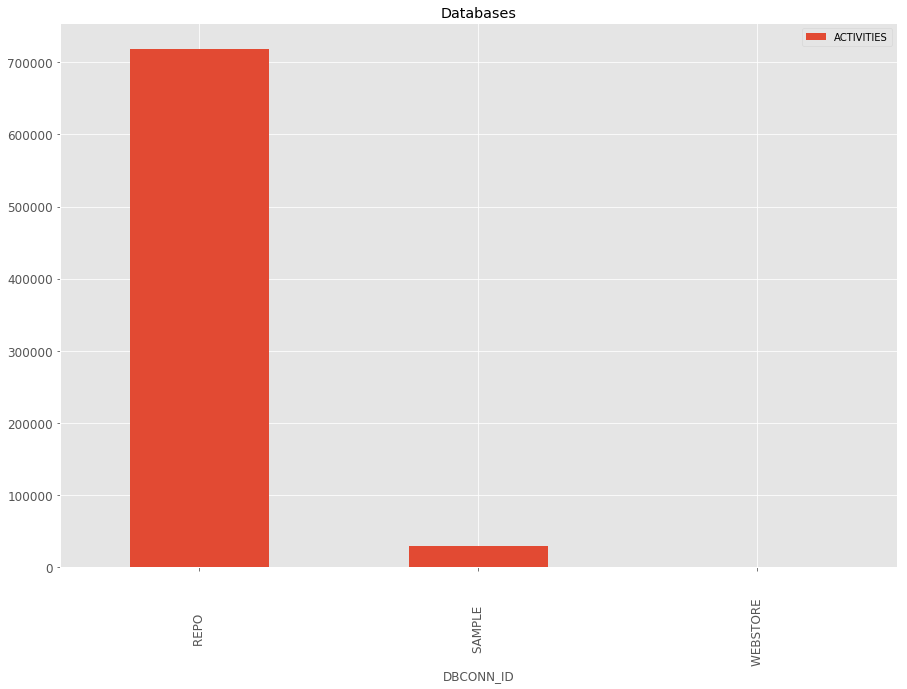

In [45]:
# graph the transactions per database
sum_transactions.plot(x='DBCONN_ID',y='ACTIVITIES',kind='bar', title ="Databases", figsize=(15, 10), legend=True, fontsize=12)
plt.show()